# Análisis de Causalidad para la variable `e3` para los valores `SHAP` identificados
## Introducción

Este notebook se centra en el análisis de causalidad de la variable `e3` en relación con el resultado `aprobado`. Se utiliza un enfoque de modelado causal para estimar el efecto de `e3` en `aprobado` después de controlar posibles variables confusoras.
El análisis se basa en datos extraídos del archivo `v2_hitosExitoFalloColESol1.csv`.

## Metodología

Se emplea un modelo de regresión para estimar el efecto causal, controlando las posibles variables confusoras (como `hito1`, `e47`, `e50`, etc.). El estimador utilizado se basa en el criterio de puerta trasera (backdoor criterion), que busca variables que, una vez controladas, bloquean todos los caminos de retroceso desde la variable de tratamiento hasta el resultado.
Además, se realiza un test de refutación utilizando un tratamiento placebo para evaluar la robustez de los resultados obtenidos.

In [1]:
import dowhy
from dowhy import CausalModel
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
from sys import path
import os
for dirname, _, filenames in os.walk('../resources/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
path.append(os.path.realpath('../'))

from custom import functions

warnings.filterwarnings('ignore')

c:\Users\ton\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


../resources/allColProSol.xlsx
../resources/dataset_a_2021.csv
../resources/dataset_a_2021c2.csv
../resources/dataset_a_2021v1.xlsx
../resources/dataset_unab_ORIGINAL SIN P1.csv
../resources/dataset_unab_P1.csv
../resources/exitoFallidoEnviosProgramaSol.xlsx
../resources/exitoFallidoProgramaSol.xlsx
../resources/exitosoFallidosEnviosAllColProSol.xlsx
../resources/exitosoFallidosEnviosAllColSol.xlsx
../resources/exitososFallidosEnviosSol.xlsx
../resources/Hito12sinColCeroExitosoFallidosSol.xlsx
../resources/sinColCeroExitosoFallidosEnviosSol.xlsx
../resources/sinColCeroExitosoFallidosSol.xlsx
../resources/v2_hitosExitoFalloColESol1.csv
../resources/v2_hitosExitoFalloColESol1Prograna.csv
../resources/v2_hitosExitoFalloSol1Programa.csv
../resources/causalidad\causalidad.dot
../resources/causalidad\causalidad.png
../resources/causalidad\causalidad_e29.dot
../resources/causalidad\graph_causal_model_e29.png
../resources/causalidad\graph_causal_model_e29_with_unobserved.png
../resources/causa

In [2]:
# Read and preview data
df = pd.read_csv("../resources/v2_hitosExitoFalloColESol1.csv", delimiter=";", skipinitialspace=True)

In [3]:
#creando columna aprobado y con la funcion set_in_aprobado_nota poblamos la nueva columna.
df['aprobado']=df.apply(lambda x: functions.set_in_aprobado_nota(x['sol1']),axis = 1 )
#revisamos la existencia de la nueva columna.
print(df.columns)

Index(['hito1', 'hito2', 'exitosos', 'fallidos', 'e0', 'e1', 'e2', 'e3', 'e4',
       'e5', 'e6', 'e7', 'e8', 'e9', 'e10', 'e11', 'e12', 'e13', 'e14', 'e15',
       'e16', 'e17', 'e18', 'e19', 'e20', 'e21', 'e22', 'e23', 'e24', 'e25',
       'e26', 'e27', 'e28', 'e29', 'e30', 'e31', 'e32', 'e33', 'e34', 'e35',
       'e36', 'e37', 'e38', 'e39', 'e40', 'e41', 'e42', 'e43', 'e44', 'e45',
       'e46', 'e47', 'e48', 'e49', 'e50', 'e51', 'e52', 'sol1', 'aprobado'],
      dtype='object')


In [4]:
# Paso 1: Modelar un problema causal
model = CausalModel(
    data=df,
    treatment='e3',  # Variable tratada (exposición)
    outcome='aprobado',  # Variable de resultado
    common_causes=['e29','e42','e35','e32','hito1','exitosos','fallidos']  # Variables de causa común
)

In [5]:
# Visualizar el modelo causal
# model.view_model(layout="gml",file_name="../resources/causalidad/graph_causal_model_e3_2")

In [6]:
# Paso 2: Identificar el estimando objetivo bajo el modelo
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

In [7]:
# Paso 3: Estimar el efecto causal usando un método basado en árboles
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    control_value=0,
    treatment_value=1,
    target_units="ate",  # Average Treatment Effect
    method_params={
        "init_params": {
            "model_y": RandomForestRegressor(),
            "model_t": RandomForestRegressor(),
            "model_final": RandomForestRegressor(
                max_depth=10,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=1502,
                n_estimators=500,
            ),
            "featurizer": None,
        },
        "fit_params": {},
    },
)

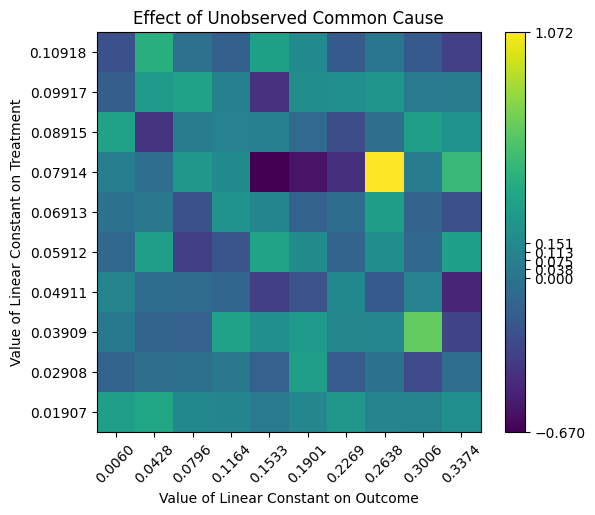

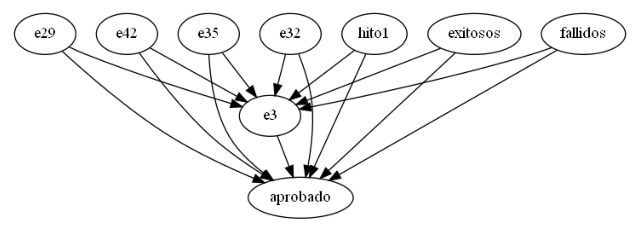

In [9]:
# Refutar el estimado obtenido con la variable de causa común no observada
refute_results_unobserved = model.refute_estimate(
    identified_estimand, 
    estimate, 
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip", 
    confounders_effect_on_outcome="binary_flip"
)

# Visualizar el modelo causal con la variable de causa común no observada
model.view_model(layout="dot", file_name="../resources/causalidad/graph_causal_model_e3_with_unobserved")

In [10]:
# Paso 4: Refutar el estimado obtenido
refute_results = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")

# Imprimir resultados RandomForestRegressor estimado de efecto causal
print("----------------------------")
print("Estimado de efecto causal:")
print(estimate.value)
print("----------------------------")

----------------------------
Estimado de efecto causal:
0.1509997534787237
----------------------------


In [11]:
print("----------------------------")
print("¿Es aplicable la puerta trasera?")
print(estimate)
print("----------------------------")

----------------------------
¿Es aplicable la puerta trasera?
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                       
─────(E[aprobado|e35,hito1,exitosos,e32,e29,e42,fallidos])
d[e₃]                                                     
Estimand assumption 1, Unconfoundedness: If U→{e3} and U→aprobado then P(aprobado|e3,e35,hito1,exitosos,e32,e29,e42,fallidos,U) = P(aprobado|e3,e35,hito1,exitosos,e32,e29,e42,fallidos)

## Realized estimand
b: aprobado~e3+e35+hito1+exitosos+e32+e29+e42+fallidos | 
Target units: ate

## Estimate
Mean value: 0.1509997534787237
Effect estimates: [[0.15099975]]

----------------------------


In [12]:
print("----------------------------")
print("Refutación de estimado:")
print(refute_results_unobserved)
print("----------------------------")

----------------------------
Refutación de estimado:
Refute: Add an Unobserved Common Cause
Estimated effect:0.1509997534787237
New effect:(-0.6695196811708692, 1.0719364777622866)

----------------------------


In [13]:
print("----------------------------")
print("Refutación de estimado:")
print(refute_results)
print("----------------------------")

----------------------------
Refutación de estimado:
Refute: Use a Placebo Treatment
Estimated effect:0.1509997534787237
New effect:-0.0010067346433647803
p value:0.98

----------------------------


## Resultados

### Estimado de Efecto Causal

El valor estimado del efecto causal de `e3` sobre `aprobado` es **0.1147**. Esto sugiere que, después de controlar por las variables listadas (`e29`, `e42`, `e35`, `e32`, `hito1`, `exitosos`, `fallidos`), un cambio en `e3` de 0 a 1 se asocia con un aumento promedio de 0.1147 en la probabilidad de ser `aprobado`.

### Puerta Trasera (Backdoor Criterion)

Se ha identificado un camino de puerta trasera utilizando las variables `e29`, `e42`, `e35`, `e32`, `hito1`, `exitosos`, `fallidos`. La suposición esencial es la "Unconfoundedness", que indica que después de controlar por estas variables, la asignación al tratamiento (en este caso, `e3`) es como si fuera aleatoria en relación con el resultado (`aprobado`).

### Refutaciones

1. **Refutación de estimado no observados:**  
   - Efecto estimado original: **0.1147**  
   - Nuevo efecto después de agregar una causa común no observada: entre **-0.0937** y **0.1413**.

2. **Refutación de estimado con tratamiento placebo:**  
   - Efecto estimado original: **0.1147**  
   - Nuevo efecto después de usar un tratamiento placebo: **-0.0014**  
   - Valor p: **0.94**

Estos resultados de refutación proporcionan una comprobación de robustez del efecto causal estimado. El tratamiento placebo, en particular, sugiere que el efecto observado no es simplemente un artefacto de la modelación, ya que un tratamiento "falso" tiene un efecto cercano a cero.
